In [209]:
import glob
import os
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
%matplotlib inline

CAMERA_CALIBRATION_FILE = './camera_cal/calibrated_data.p'

class Camera:
    def __init__(self, calibration_images, corners_x, corners_y,
                 reuse_mtx=True):
        self.calibration_images = calibration_images
        self.corners_x = corners_x
        self.corners_y = corners_y
        self.object_points = []
        self.image_points = []

        if not reuse_mtx:
            self._calibrate()

    def _calibrate(self):
        object_point = np.zeros((self.corners_x * self.corners_y, 3), np.float32)
        object_point[:, :2] = np.mgrid[0:self.corners_x, 0:self.corners_y].T.reshape(-1, 2)

        for idx, file_name in enumerate(self.calibration_images):
            image = cv2.imread(file_name)
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            ret, corners = cv2.findChessboardCorners(gray_image,
                                                     (self.corners_x, self.corners_y),
                                                     None)
            if ret:
                self.object_points.append(object_point)
                self.image_points.append(corners)

        image_size = (image.shape[1], image.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.object_points,
                                                           self.image_points, image_size, None, None)
        calibrated_data = {'mtx': mtx, 'dist': dist}

        with open(CAMERA_CALIBRATION_COEFFICIENTS_FILE, 'wb') as f:
            pickle.dump(calibrated_data, file=f)

    def undistort(self,image, path='',show=False,rgb=False,save=False):
     
        if not os.path.exists(CAMERA_CALIBRATION_FILE):
            raise Exception('Camera calibration data file does not exist at ' +
                            CAMERA_CALIBRATION_FILE)

        with open(CAMERA_CALIBRATION_FILE, 'rb') as f:
            calibrated_data = pickle.load(file=f)
        
        undistorted = cv2.undistort(image, calibrated_data['mtx'], calibrated_data['dist'],
                             None, calibrated_data['mtx'])
            
        if save == True:
            head, tail = os.path.split(path)
            cv2.imwrite('./output_images/undistorted/'+tail, undistorted)
        
        if show == True:
            visualize(image,undistorted,rgb)
            
        return undistorted
       
    
    def batch_undistort(self, dirpath,show=False,rgb=False,save=True):
        images=[]
        paths = os.listdir(dirpath)
        for path in paths:
            #print(path)
            image = cv2.imread(dirpath+'/'+path)
            self.undistort(image,path,show,rgb,save)
    
    @staticmethod
    def get_instance():
        calibration_images = glob.glob('./camera_cal/calibration*.jpg')
        camera = Camera(calibration_images,
                                      9, 6, reuse_mtx=True)
        return camera
    
    @staticmethod
    def run(calimages,input,output):
        calibration_images = glob.glob(calimages)
        camera = Camera(calibration_images, 9, 6,output)
        distorted = camera.batch_undistort(input,show=True,rgb=True)
        
class Perspective:
    def __init__(self, src_points, dest_points):
        self.src_points = src_points
        self.dest_points = dest_points

        self.M = cv2.getPerspectiveTransform(self.src_points, self.dest_points)
        self.M_inverse = cv2.getPerspectiveTransform(self.dest_points, self.src_points)

    def transform(self, image,path='', show=False,rgb=False,save=False):
        size = (image.shape[1], image.shape[0])
        
        warped = cv2.warpPerspective(image, self.M, size, flags=cv2.INTER_LINEAR)
        if save:
            #head, tail = os.path.split(output)
            cv2.imwrite(path, warped)
       
        if show :
            visualize(image,warped,rgb)
        return warped

    def inverse_transform(self, src_image):
        size = (src_image.shape[1], src_image.shape[0])
        return cv2.warpPerspective(src_image, self.M_inverse, size, flags=cv2.INTER_LINEAR)
    
    @staticmethod
    def get_instance():
        corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
        new_top_left = np.array([corners[0, 0], 0])
        new_top_right = np.array([corners[3, 0], 0])
        offset = [50, 0]

        src = np.float32([corners[0], corners[1], corners[2], corners[3]])
        dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])

        perspective = Perspective(src, dst)
        return perspective
    
    @staticmethod
    def drawlines(path,btleft,topleft,topright,btright):
        image = cv2.imread(path)
        cv2.line(image, (btleft[0], btleft[1]), (topleft[0],topleft[1]), color=[255,0,0], thickness=2)
        cv2.line(image, (topleft[0],topleft[1]), (topright[0],topright[1]), color=[255,0,0], thickness=2)
        cv2.line(image, (topright[0],topright[1]), (btright[0],btright[1]), color=[255,0,0], thickness=2)
        cv2.line(image, (btright[0],btright[1]), (btleft[0], btleft[1]), color=[255,0,0], thickness=2)
        return image
    
    @staticmethod
    def batch_transform(input,output,perspective,btleft,topleft,topright,btright):
        paths = os.listdir(input)
        for path in paths:
            image = Perspective.drawlines(input+path,btleft,topleft,topright,btright)
            perspective.transform(cv2.imread(input+path),output+path,show=True,rgb=True,save=True)
    @staticmethod
    def run(corners,input,output):
        perspective = Perspective.get_instance()
        #perspective = Perspective.get_instance(corners[0],corners[1],corners[2],corners[3])
        image = Perspective.drawlines('./output_images/undistorted/straight_lines2.jpg',[253, 697],[585,456],[700, 456],[1061,690])
        perspective.transform(image,'./output_images/warped/straight_lines2.jpg',show=True,rgb=True,save=True)
        Perspective.batch_transform('./output_images/undistorted/','./output_images/warped/', \
                                    perspective,[253, 697],[585,456],[700, 456],[1061,690])
        
class Binarizer():
    
    def __init__(self):
        self.output = None
    
    def noise_reduction(self,image, threshold=4):
        k = np.array([[1, 1, 1],
                      [1, 0, 1],
                      [1, 1, 1]])
        nb_neighbours = cv2.filter2D(image, ddepth=-1, kernel=k)
        image[nb_neighbours < threshold] = 0
        return image


    def binarize(self,image, path='', gray_thresh=(20, 255), s_thresh=(170, 255), \
                    l_thresh=(30, 255), sobel_kernel=3,show=False,rgb=False,save=False):
        # first we take a copy of the source iamge
        image_copy = np.copy(image)
        #visualize(image,image_copy)
        # convert RGB image to HLS color space.
        # HLS more reliable when it comes to find out lane lines
        hls = cv2.cvtColor(image_copy, cv2.COLOR_RGB2HLS)
        s_channel = hls[:, :, 2]
        l_channel = hls[:, :, 1]

        # Next, we apply Sobel operator in X direction and calculate scaled derivatives.
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

        # Next, we generate a binary image based on gray_thresh values.
        thresh_min = gray_thresh[0]
        thresh_max = gray_thresh[1]
        sobel_x_binary = np.zeros_like(scaled_sobel)
        sobel_x_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Next, we generated a binary image using S component of our HLS color scheme and
        # provided S threshold
        s_binary = np.zeros_like(s_channel)
        s_thresh_min = s_thresh[0]
        s_thresh_max = s_thresh[1]
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        # Next, we generated a binary image using S component of our HLS color scheme and
        # provided S threshold
        l_binary = np.zeros_like(l_channel)
        l_thresh_min = l_thresh[0]
        l_thresh_max = l_thresh[1]
        l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

        # finally, return the combined binary image
        binary = np.zeros_like(sobel_x_binary)
        binary[((l_binary == 1) & (s_binary == 1) | (sobel_x_binary == 1))] = 1
        binary = 255 * np.dstack((binary, binary, binary)).astype('uint8')
        binary = noise_reduction(binary)
        
        if save == True:
            #head, tail = os.path.split(path)
            cv2.imwrite(self.output+path, binary)
            
        if show == True:
            visualize(image,binary,rgb)
       
        return binary
    
    @staticmethod
    def run(input,output, gray_thresh=(20, 255), s_thresh=(170, 255), \
                    l_thresh=(30, 255), sobel_kernel=3,show=True,rgb=False,save=True):
        
        binarizer = Binarizer.get_instance()
        paths = os.listdir(input)
        binarizer.output = output
        print(binarizer.output)
        for path in paths:
            image = np.copy(cv2.imread(input+path))
            
            binarizer.binarize(image,path, gray_thresh=(20, 255), s_thresh=(170, 255), \
                    l_thresh=(30, 255), sobel_kernel=3,show=True,rgb=False,save=True)

    @staticmethod
    def get_instance():
        return Binarizer()
            
            
def visualize(distorted,undistorted,rgb=False):
    # Display both distorted and undistorted images
    if rgb == True:
        distorted = cv2.cvtColor(distorted, cv2.COLOR_BGR2RGB)
        undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('Distorted Image')
    plt.imshow(distorted)
    plt.subplot(1, 2, 2)
    plt.imshow(undistorted)
    plt.axis('off')
    plt.title('Undistorted Image')

    plt.show()            
            
            
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):

        self.detected = False

        self.left_fit = None
        self.right_fit = None

        self.MAX_BUFFER_SIZE = 12

        self.buffer_index = 0
        self.iter_counter = 0

        self.buffer_left = np.zeros((self.MAX_BUFFER_SIZE, 720))
        self.buffer_right = np.zeros((self.MAX_BUFFER_SIZE, 720))

        self.perspective = Perspective.get_instance()
        self.camera = Camera.get_instance()

    def firstime_extractor(self, binary_warped,show=False):
        histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :, 0], axis=0)
        if show :
            plt.figure(figsize=(8, 3))
            plt.plot(histogram)
            plt.show()
        # get midpoint of the histogram
        midpoint = np.int(histogram.shape[0] / 2)

        # get left and right halves of the histogram
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # based on number of events, we calculate hight of a window
        nwindows = 9
        window_height = np.int(binary_warped.shape[0] / nwindows)

        # Extracts x and y coordinates of non-zero pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Set current x coordinated for left and right
        leftx_current = leftx_base
        rightx_current = rightx_base

        margin = 75
        min_num_pixels = 35

        # save pixel ids in these two lists
        left_lane_inds = []
        right_lane_inds = []

        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            win_y_high = binary_warped.shape[0] - window * window_height

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
                nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
                nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > min_num_pixels:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > min_num_pixels:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)

        fity = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        fit_leftx = self.left_fit[0] * fity ** 2 + self.left_fit[1] * fity + self.left_fit[2]
        fit_rightx = self.right_fit[0] * fity ** 2 + self.right_fit[1] * fity + self.right_fit[2]

        self.detected = True
        
        if show:
            binary_warped[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            binary_warped[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            plt.imshow(binary_warped)
            plt.plot(fit_leftx, fity, color='yellow')
            plt.plot(fit_rightx, fity, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.show()
        
        return fit_leftx, fit_rightx

    def lazy_extractor(self, binary_warped):
      # Assume you now have a new warped binary image
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        margin = 75

        left_lane_inds = (
            (nonzerox > (
                self.left_fit[0] * (nonzeroy ** 2) + self.left_fit[1] * nonzeroy + self.left_fit[2] - margin)) & (
                nonzerox < (
                    self.left_fit[0] * (nonzeroy ** 2) + self.left_fit[1] * nonzeroy + self.left_fit[2] + margin)))
        right_lane_inds = (
            (nonzerox > (
                self.right_fit[0] * (nonzeroy ** 2) + self.right_fit[1] * nonzeroy + self.right_fit[2] - margin)) & (
                nonzerox < (
                    self.right_fit[0] * (nonzeroy ** 2) + self.right_fit[1] * nonzeroy + self.right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        left_fitx = self.left_fit[0] * ploty ** 2 + self.left_fit[1] * ploty + self.left_fit[2]
        right_fitx = self.right_fit[0] * ploty ** 2 + self.right_fit[1] * ploty + self.right_fit[2]

        return left_fitx, right_fitx

    def lane_properties(self, image_size, left_x, right_x):
        # first we calculate the intercept points at the bottom of our image
        left_intercept = self.left_fit[0] * image_size[0] ** 2 + self.left_fit[1] * image_size[0] + self.left_fit[2]
        right_intercept = self.right_fit[0] * image_size[0] ** 2 + self.right_fit[1] * image_size[0] + self.right_fit[2]

        # Next take the difference in pixels between left and right interceptor points
        road_width_in_pixels = right_intercept - left_intercept
        assert road_width_in_pixels > 0, 'Road width in pixel can not be negative'

        # Since average highway lane line width in US is about 3.7m
        # Source: https://en.wikipedia.org/wiki/Lane#Lane_width
        # we calculate length per pixel in meters
        meters_per_pixel_x_dir = 3.7 / road_width_in_pixels
        meters_per_pixel_y_dir = 30 / road_width_in_pixels

        # Recalculate road curvature in X-Y space
        ploty = np.linspace(0, 719, num=720)
        y_eval = np.max(ploty)

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty * meters_per_pixel_y_dir, left_x * meters_per_pixel_x_dir, 2)
        right_fit_cr = np.polyfit(ploty * meters_per_pixel_y_dir, right_x * meters_per_pixel_x_dir, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * meters_per_pixel_y_dir + left_fit_cr[1]) ** 2) ** 1.5) / \
                        np.absolute(2 * left_fit_cr[0])

        right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * meters_per_pixel_y_dir + right_fit_cr[1]) ** 2) ** 1.5) / \
                         np.absolute(2 * right_fit_cr[0])

        # Next, we can lane deviation
        calculated_center = (left_intercept + right_intercept) / 2.0
        lane_deviation = (calculated_center - image_size[1] / 2.0) * meters_per_pixel_x_dir

        return left_curverad, right_curverad, lane_deviation

    @staticmethod
    def fill_lane(image, fit_left_x, fit_right_x):
        copy_image = np.zeros_like(image)
        fit_y = np.linspace(0, copy_image.shape[0] - 1, copy_image.shape[0])

        pts_left = np.array([np.transpose(np.vstack([fit_left_x, fit_y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_right_x, fit_y])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.fillPoly(copy_image, np.int_([pts]), (0, 255, 0))

        return copy_image

    def fuse(self, binary_img, src_image):
        copy_binary = np.copy(binary_img)
        copy_src_img = np.copy(src_image)

        copy_binary_pers = self.perspective.inverse_transform(copy_binary)
        result = cv2.addWeighted(copy_src_img, 1, copy_binary_pers, 0.3, 0)

        return result

    def run(self, image):
        image = np.copy(image)
        undistorted_image = self.camera.undistort(image)
        warped_image = self.perspective.transform(undistorted_image)
      
        #visualize(undistorted_image,warped_image)
    
        binarizer = Binarizer.get_instance()
        binary_image = binarizer.binarize(warped_image)

        if self.detected:
            fit_leftx, fit_rightx = self.lazy_extractor(binary_image)
        else:
            fit_leftx, fit_rightx = self.firstime_extractor(binary_image,show=True)

        self.buffer_left[self.buffer_index] = fit_leftx
        self.buffer_right[self.buffer_index] = fit_rightx

        self.buffer_index += 1
        self.buffer_index %= self.MAX_BUFFER_SIZE

        if self.iter_counter < self.MAX_BUFFER_SIZE:
            self.iter_counter += 1
            ave_left = np.sum(self.buffer_left, axis=0) / self.iter_counter
            ave_right = np.sum(self.buffer_right, axis=0) / self.iter_counter
        else:
            ave_left = np.average(self.buffer_left, axis=0)
            ave_right = np.average(self.buffer_right, axis=0)

        left_curvature, right_curvature, calculated_deviation = self.lane_properties(image.shape, ave_left,
                                                                                         ave_right)
        curvature_text = 'Left Curvature: {:.2f} m    Right Curvature: {:.2f} m'.format(left_curvature, right_curvature)
        left_curv_text = 'Left Curvature: {:.2f} m'.format(left_curvature)
        right_curv_text = 'Right Curvature: {:.2f} m'.format(right_curvature)
                                                           
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image, left_curv_text, (100, 50), font, 1, (200,255,155), 2)
        cv2.putText(image, right_curv_text, (100, 100), font, 1, (200,255,155), 2)

        deviation_info = 'Lane Deviation: {:.3f} m'.format(calculated_deviation)
        cv2.putText(image, deviation_info, (100, 150), font, 1, (200,255,155), 2)

        filled_image = self.fill_lane(binary_image, ave_left, ave_right)

        merged_image = self.fuse(filled_image, image)

        return merged_image

def process_video():
    from moviepy.editor import VideoFileClip

    line = Line()
    output_file = './processed_project_video.mp4'
    input_file = './project_video.mp4'
    clip = VideoFileClip(input_file)
    out_clip = clip.fl_image(line.run)
    out_clip.write_videofile(output_file, audio=False)
    
def main(args):
    if args == 'video':
        process_video()
    if args == 'undistort':
        calimages = './camera_cal/calibration*.jpg'
        input = './test_images/'
        output = './output_images/undistorted/'
        Camera.run(calimages,input,output)
    if args == 'warp':
        input = './output_images/undistorted/'
        output = './output_images/warped/'
        Perspective.run([[253, 697],[585,456],[700, 456],[1061,690]],input,output)
    if args == 'binarize':
        input='./output_images/warped/'
        output = './output_images/binarized/'
        Binarizer.run(input,output)


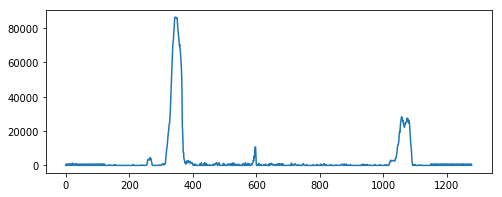

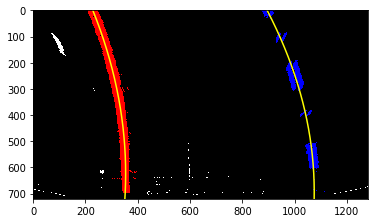

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4



100%|█████████▉| 1260/1261 [04:35<00:00,  4.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 



In [210]:
main('video')

In [211]:
#main('undistort')

In [212]:
#main('warp')

In [213]:
#main('binarize')